In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from hmmlearn import hmm

In [2]:
input_df = pd.read_csv('~/Desktop/Corbin SBU/AMS 520/Project/BofA Projects Data/EOD_20210908.csv',
                       header = None,
                       names = ['Ticker', # Label columns.
                                'Date',
                                'Open',
                                'High',
                                'Low',
                                'Close',
                                'Volume',
                                'Dividend',
                                'Stock_split',
                                'Adj_open',
                                'Adj_high',
                                'Adj_low',
                                'Adj_close',
                                'Adj_volume'])

In [3]:
data = input_df.loc[input_df['Ticker'] == 'SPY'] # Select which index to use for analysis

In [4]:
data.reset_index(inplace=True, drop=True)

In [489]:
data

,Ticker,Date,Open,High,Low,Close,Volume,Dividend,Stock_split,Adj_open,Adj_high,Adj_low,Adj_close,Adj_volume,Return,Volatility
0,SPY,1993-01-29,43.9687,43.9687,43.7500,43.9375,1003200.0,0.0,1.0,25.804239,25.804239,25.675889,25.785928,1003200.0,NaN,0.000000
1,SPY,1993-02-01,43.9687,44.2500,43.9687,44.2500,480500.0,0.0,1.0,25.804239,25.969328,25.804239,25.969328,480500.0,0.711238,0.000000
2,SPY,1993-02-02,44.2187,44.3750,44.1250,44.3437,201300.0,0.0,1.0,25.950958,26.042687,25.895968,26.024318,201300.0,0.211751,0.000000
3,SPY,1993-02-03,44.4062,44.8437,44.3750,44.8125,529400.0,0.0,1.0,26.060998,26.317757,26.042687,26.299446,529400.0,1.057196,0.000000
4,SPY,1993-02-04,44.9687,45.0937,44.4687,45.0000,531500.0,0.0,1.0,26.391117,26.464476,26.097678,26.409486,531500.0,0.418410,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7199,SPY,2021-08-31,452.1300,452.4900,450.9200,451.5600,58631140.0,0.0,1.0,452.130000,452.490000,450.920000,451.560000,58631140.0,-0.148155,0.923143
7200,SPY,2021-09-01,452.5600,453.1100,451.5450,451.8000,48667698.0,0.0,1.0,452.560000,453.110000,451.545000,451.800000,48667698.0,0.053149,0.922691
7201,SPY,2021-09-02,453.3200,454.0500,451.9100,453.1900,42479834.0,0.0,1.0,453.320000,454.050000,451.910000,453.190000,42479834.0,0.307658,0.922626
7202,SPY,2021-09-03,451.9800,453.6300,451.5500,453.0800,47155405.0,0.0,1.0,451.980000,453.630000,451.550000,453.080000,47155405.0,-0.024272,0.922585


In [418]:
Neff = 260 # Lookback length

#Return = np.log(data['Adj_close']) - np.log(data['Adj_close']).shift(1) # Calculate daily log returns
Return = 100*(data['Adj_close'] - data['Adj_close'].shift(1)) / data['Adj_close'].shift(1) # Calculate daily percentage returns

data['Return'] = Return

<ipython-input-418-0947ad6c36dd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Return'] = Return


In [419]:
Volatility = np.concatenate((np.zeros(Neff),
                             [np.sqrt(sum((data['Return'][i:Neff+i] - np.mean(data['Return'][i:Neff+i]))**2) / Neff) for i in range(len(data)-Neff)])) # Calculate volatility for trailing Neff days

data['Volatility'] = Volatility

<ipython-input-419-696cdfb538a2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Volatility'] = Volatility


In [420]:
# Idea:
# Create a HMM for the recent Neff days, for all days after the Neff'th day
# Predict which state we are currently in based on the Neff recent days
# Be fully invested if in a positive market, full divested in a negative market


# Initialize a HMM
states = 2
max_iterations = 100

current_state = np.array([])

for i in range(1, len(data) - 2*Neff):
    model = hmm.GaussianHMM(n_components = states, covariance_type="full", n_iter = max_iterations);
    
    observations = np.stack((data['Volatility'][Neff+i:Neff*2+i], data['Return'][Neff+i:Neff*2+i]), axis=1)
    
    model.fit(observations)

    print(f'i = {i}')
    
    if model.means_[0,1] > model.means_[1,1]:
        positive_state = 0
    else:
        positive_state = 1
    
    predictions = model.predict(observations)
    
    if positive_state == 1:
        pass
    else:
        zeros = np.where(predictions == 0)
        ones = np.where(predictions == 1)
        predictions[zeros] = 1
        predictions[ones] = 0
        
    current_state = np.append(current_state,predictions[-1])
        
current_state = current_state.astype(np.int64)

i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121
i = 122
i = 123
i = 124
i = 125
i = 126
i = 127
i = 128
i = 129
i = 130
i = 131
i = 132
i = 133
i = 134
i = 135
i = 136
i = 137
i = 138
i = 

i = 1036
i = 1037
i = 1038
i = 1039
i = 1040
i = 1041
i = 1042
i = 1043
i = 1044
i = 1045
i = 1046
i = 1047
i = 1048
i = 1049
i = 1050
i = 1051
i = 1052
i = 1053
i = 1054
i = 1055
i = 1056
i = 1057
i = 1058
i = 1059
i = 1060
i = 1061
i = 1062
i = 1063
i = 1064
i = 1065
i = 1066
i = 1067
i = 1068
i = 1069
i = 1070
i = 1071
i = 1072
i = 1073
i = 1074
i = 1075
i = 1076
i = 1077
i = 1078
i = 1079
i = 1080
i = 1081
i = 1082
i = 1083
i = 1084
i = 1085
i = 1086
i = 1087
i = 1088
i = 1089
i = 1090
i = 1091
i = 1092
i = 1093
i = 1094
i = 1095
i = 1096
i = 1097
i = 1098
i = 1099
i = 1100
i = 1101
i = 1102
i = 1103
i = 1104
i = 1105
i = 1106
i = 1107
i = 1108
i = 1109
i = 1110
i = 1111
i = 1112
i = 1113
i = 1114
i = 1115
i = 1116
i = 1117
i = 1118
i = 1119
i = 1120
i = 1121
i = 1122
i = 1123
i = 1124
i = 1125
i = 1126
i = 1127
i = 1128
i = 1129
i = 1130
i = 1131
i = 1132
i = 1133
i = 1134
i = 1135
i = 1136
i = 1137
i = 1138
i = 1139
i = 1140
i = 1141
i = 1142
i = 1143
i = 1144
i = 1145
i = 1146
i

i = 1947
i = 1948
i = 1949
i = 1950
i = 1951
i = 1952
i = 1953
i = 1954
i = 1955
i = 1956
i = 1957
i = 1958
i = 1959
i = 1960
i = 1961
i = 1962
i = 1963
i = 1964
i = 1965
i = 1966
i = 1967
i = 1968
i = 1969
i = 1970
i = 1971
i = 1972
i = 1973
i = 1974
i = 1975
i = 1976
i = 1977
i = 1978
i = 1979
i = 1980
i = 1981
i = 1982
i = 1983
i = 1984
i = 1985
i = 1986
i = 1987
i = 1988
i = 1989
i = 1990
i = 1991
i = 1992
i = 1993
i = 1994
i = 1995
i = 1996
i = 1997
i = 1998
i = 1999
i = 2000
i = 2001
i = 2002
i = 2003
i = 2004
i = 2005
i = 2006
i = 2007
i = 2008
i = 2009
i = 2010
i = 2011
i = 2012
i = 2013
i = 2014
i = 2015
i = 2016
i = 2017
i = 2018
i = 2019
i = 2020
i = 2021
i = 2022
i = 2023
i = 2024
i = 2025
i = 2026
i = 2027
i = 2028
i = 2029
i = 2030
i = 2031
i = 2032
i = 2033
i = 2034
i = 2035
i = 2036
i = 2037
i = 2038
i = 2039
i = 2040
i = 2041
i = 2042
i = 2043
i = 2044
i = 2045
i = 2046
i = 2047
i = 2048
i = 2049
i = 2050
i = 2051
i = 2052
i = 2053
i = 2054
i = 2055
i = 2056
i = 2057
i

i = 2860
i = 2861
i = 2862
i = 2863
i = 2864
i = 2865
i = 2866
i = 2867
i = 2868
i = 2869
i = 2870
i = 2871
i = 2872
i = 2873
i = 2874
i = 2875
i = 2876
i = 2877
i = 2878
i = 2879
i = 2880
i = 2881
i = 2882
i = 2883
i = 2884
i = 2885
i = 2886
i = 2887
i = 2888
i = 2889
i = 2890
i = 2891
i = 2892
i = 2893
i = 2894
i = 2895
i = 2896
i = 2897
i = 2898
i = 2899
i = 2900
i = 2901
i = 2902
i = 2903
i = 2904
i = 2905
i = 2906
i = 2907
i = 2908
i = 2909
i = 2910
i = 2911
i = 2912
i = 2913
i = 2914
i = 2915
i = 2916
i = 2917
i = 2918
i = 2919
i = 2920
i = 2921
i = 2922
i = 2923
i = 2924
i = 2925
i = 2926
i = 2927
i = 2928
i = 2929
i = 2930
i = 2931
i = 2932
i = 2933
i = 2934
i = 2935
i = 2936
i = 2937
i = 2938
i = 2939
i = 2940
i = 2941
i = 2942
i = 2943
i = 2944
i = 2945
i = 2946
i = 2947
i = 2948
i = 2949
i = 2950
i = 2951
i = 2952
i = 2953
i = 2954
i = 2955
i = 2956
i = 2957
i = 2958
i = 2959
i = 2960
i = 2961
i = 2962
i = 2963
i = 2964
i = 2965
i = 2966
i = 2967
i = 2968
i = 2969
i = 2970
i

i = 3773
i = 3774
i = 3775
i = 3776
i = 3777
i = 3778
i = 3779
i = 3780
i = 3781
i = 3782
i = 3783
i = 3784
i = 3785
i = 3786
i = 3787
i = 3788
i = 3789
i = 3790
i = 3791
i = 3792
i = 3793
i = 3794
i = 3795
i = 3796
i = 3797
i = 3798
i = 3799
i = 3800
i = 3801
i = 3802
i = 3803
i = 3804
i = 3805
i = 3806
i = 3807
i = 3808
i = 3809
i = 3810
i = 3811
i = 3812
i = 3813
i = 3814
i = 3815
i = 3816
i = 3817
i = 3818
i = 3819
i = 3820
i = 3821
i = 3822
i = 3823
i = 3824
i = 3825
i = 3826
i = 3827
i = 3828
i = 3829
i = 3830
i = 3831
i = 3832
i = 3833
i = 3834
i = 3835
i = 3836
i = 3837
i = 3838
i = 3839
i = 3840
i = 3841
i = 3842
i = 3843
i = 3844
i = 3845
i = 3846
i = 3847
i = 3848
i = 3849
i = 3850
i = 3851
i = 3852
i = 3853
i = 3854
i = 3855
i = 3856
i = 3857
i = 3858
i = 3859
i = 3860
i = 3861
i = 3862
i = 3863
i = 3864
i = 3865
i = 3866
i = 3867
i = 3868
i = 3869
i = 3870
i = 3871
i = 3872
i = 3873
i = 3874
i = 3875
i = 3876
i = 3877
i = 3878
i = 3879
i = 3880
i = 3881
i = 3882
i = 3883
i

i = 4686
i = 4687
i = 4688
i = 4689
i = 4690
i = 4691
i = 4692
i = 4693
i = 4694
i = 4695
i = 4696
i = 4697
i = 4698
i = 4699
i = 4700
i = 4701
i = 4702
i = 4703
i = 4704
i = 4705
i = 4706
i = 4707
i = 4708
i = 4709
i = 4710
i = 4711
i = 4712
i = 4713
i = 4714
i = 4715
i = 4716
i = 4717
i = 4718
i = 4719
i = 4720
i = 4721
i = 4722
i = 4723
i = 4724
i = 4725
i = 4726
i = 4727
i = 4728
i = 4729
i = 4730
i = 4731
i = 4732
i = 4733
i = 4734
i = 4735
i = 4736
i = 4737
i = 4738
i = 4739
i = 4740
i = 4741
i = 4742
i = 4743
i = 4744
i = 4745
i = 4746
i = 4747
i = 4748
i = 4749
i = 4750
i = 4751
i = 4752
i = 4753
i = 4754
i = 4755
i = 4756
i = 4757
i = 4758
i = 4759
i = 4760
i = 4761
i = 4762
i = 4763
i = 4764
i = 4765
i = 4766
i = 4767
i = 4768
i = 4769
i = 4770
i = 4771
i = 4772
i = 4773
i = 4774
i = 4775
i = 4776
i = 4777
i = 4778
i = 4779
i = 4780
i = 4781
i = 4782
i = 4783
i = 4784
i = 4785
i = 4786
i = 4787
i = 4788
i = 4789
i = 4790
i = 4791
i = 4792
i = 4793
i = 4794
i = 4795
i = 4796
i

i = 5597
i = 5598
i = 5599
i = 5600
i = 5601
i = 5602
i = 5603
i = 5604
i = 5605
i = 5606
i = 5607
i = 5608
i = 5609
i = 5610
i = 5611
i = 5612
i = 5613
i = 5614
i = 5615
i = 5616
i = 5617
i = 5618
i = 5619
i = 5620
i = 5621
i = 5622
i = 5623
i = 5624
i = 5625
i = 5626
i = 5627
i = 5628
i = 5629
i = 5630
i = 5631
i = 5632
i = 5633
i = 5634
i = 5635
i = 5636
i = 5637
i = 5638
i = 5639
i = 5640
i = 5641
i = 5642
i = 5643
i = 5644
i = 5645
i = 5646
i = 5647
i = 5648
i = 5649
i = 5650
i = 5651
i = 5652
i = 5653
i = 5654
i = 5655
i = 5656
i = 5657
i = 5658
i = 5659
i = 5660
i = 5661
i = 5662
i = 5663
i = 5664
i = 5665
i = 5666
i = 5667
i = 5668
i = 5669
i = 5670
i = 5671
i = 5672
i = 5673
i = 5674
i = 5675
i = 5676
i = 5677
i = 5678
i = 5679
i = 5680
i = 5681
i = 5682
i = 5683
i = 5684
i = 5685
i = 5686
i = 5687
i = 5688
i = 5689
i = 5690
i = 5691
i = 5692
i = 5693
i = 5694
i = 5695
i = 5696
i = 5697
i = 5698
i = 5699
i = 5700
i = 5701
i = 5702
i = 5703
i = 5704
i = 5705
i = 5706
i = 5707
i

i = 6509
i = 6510
i = 6511
i = 6512
i = 6513
i = 6514
i = 6515
i = 6516
i = 6517
i = 6518
i = 6519
i = 6520
i = 6521
i = 6522
i = 6523
i = 6524
i = 6525
i = 6526
i = 6527
i = 6528
i = 6529
i = 6530
i = 6531
i = 6532
i = 6533
i = 6534
i = 6535
i = 6536
i = 6537
i = 6538
i = 6539
i = 6540
i = 6541
i = 6542
i = 6543
i = 6544
i = 6545
i = 6546
i = 6547
i = 6548
i = 6549
i = 6550
i = 6551
i = 6552
i = 6553
i = 6554
i = 6555
i = 6556
i = 6557
i = 6558
i = 6559
i = 6560
i = 6561
i = 6562
i = 6563
i = 6564
i = 6565
i = 6566
i = 6567
i = 6568
i = 6569
i = 6570
i = 6571
i = 6572
i = 6573
i = 6574
i = 6575
i = 6576
i = 6577
i = 6578
i = 6579
i = 6580
i = 6581
i = 6582
i = 6583
i = 6584
i = 6585
i = 6586
i = 6587
i = 6588
i = 6589
i = 6590
i = 6591
i = 6592
i = 6593
i = 6594
i = 6595
i = 6596
i = 6597
i = 6598
i = 6599
i = 6600
i = 6601
i = 6602
i = 6603
i = 6604
i = 6605
i = 6606
i = 6607
i = 6608
i = 6609
i = 6610
i = 6611
i = 6612
i = 6613
i = 6614
i = 6615
i = 6616
i = 6617
i = 6618
i = 6619
i

In [470]:
sum(np.abs(current_state[1:] - current_state[:-1]))/len(current_state)

0.0948675744426156

In [8]:
# Alt Idea:
# Train on all data
# Be fully invested if in a positive market, full divested in a negative market


# Initialize a HMM
# states = 2
# max_iterations = 100

# model = hmm.GaussianHMM(n_components = states, covariance_type="full", n_iter = max_iterations);

# observations = np.stack((data['Volatility'][Neff+1:], data['Return'][Neff+1:]), axis=1)

# model.fit(observations)

# predictions = model.predict(observations)

# current_state = predictions

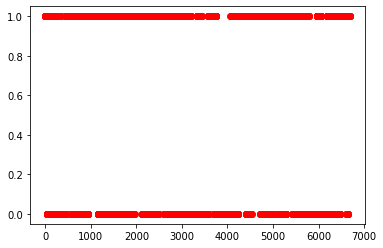

In [471]:
plt.plot(current_state, 'ro');

In [493]:
np.where(current_state)[0]+(2*Neff+1)

array([ 521,  522,  523, ..., 7201, 7202, 7203])

In [481]:
list_0 = np.where(current_state == 0)[0]+(2*Neff+1)
list_1 = np.where(current_state == 1)[0]+(2*Neff+1)

In [482]:
np.mean(data.iloc[list_0,14:16],axis=0)

Return        0.066799
Volatility    1.079798
dtype: float64

In [483]:
np.mean(data.iloc[list_1,14:16],axis=0)

Return        0.029369
Volatility    1.136113
dtype: float64

In [488]:
data.Return[list_1]

521     0.741779
522     0.160258
523     0.255754
524    -0.797349
525     0.835846
          ...   
7199   -0.148155
7200    0.053149
7201    0.307658
7202   -0.024272
7203   -0.357553
Name: Return, Length: 3355, dtype: float64

In [400]:
# Regime Classification
regime_vol = [];
regime_ret = [];
regime_count = [];
return_map = {};

for i in range(0, states):
    regime_vol.append(0);
    regime_ret.append(0);
    regime_count.append(0);

for i in range(len(current_state)):
    regime_count[current_state[i]] += 1;
    regime_vol[current_state[i]] += data.iloc[2*Neff + i + 1, 15]; # Change 'Neff + i + 1' to '2*Neff + i + 1' if using first fitting method
    regime_ret[current_state[i]] += data.iloc[2*Neff + i + 1, 14]; # Change 'Neff + i + 1' to '2*Neff + i + 1' if using first fitting method
    
    if not current_state[i] in return_map:
        return_map[current_state[i]] = [];
    return_map[current_state[i]].append(data.iloc[i,15]);
    
for i in range(0, states):
    regime_vol[i] = regime_vol[i] / regime_count[i];
    regime_ret[i] = regime_ret[i] / regime_count[i];

In [401]:
regime_ret

[0.06733414582462165, 0.02884917494412392]

In [402]:
max_occurrence = np.argmax(regime_count)
for i in range(0, states):
    print("Regime {0}".format(i))
    print("Avg Vol: {0}".format(regime_vol[i]));
    print("Avg Return: {0}".format(regime_ret[i]));
    print("Occurrence: {0}\n".format(regime_count[i]));

Regime 0
Avg Vol: 1.079473949811718
Avg Return: 0.06733414582462165
Occurrence: 3327

Regime 1
Avg Vol: 1.1364174001627043
Avg Return: 0.02884917494412392
Occurrence: 3356



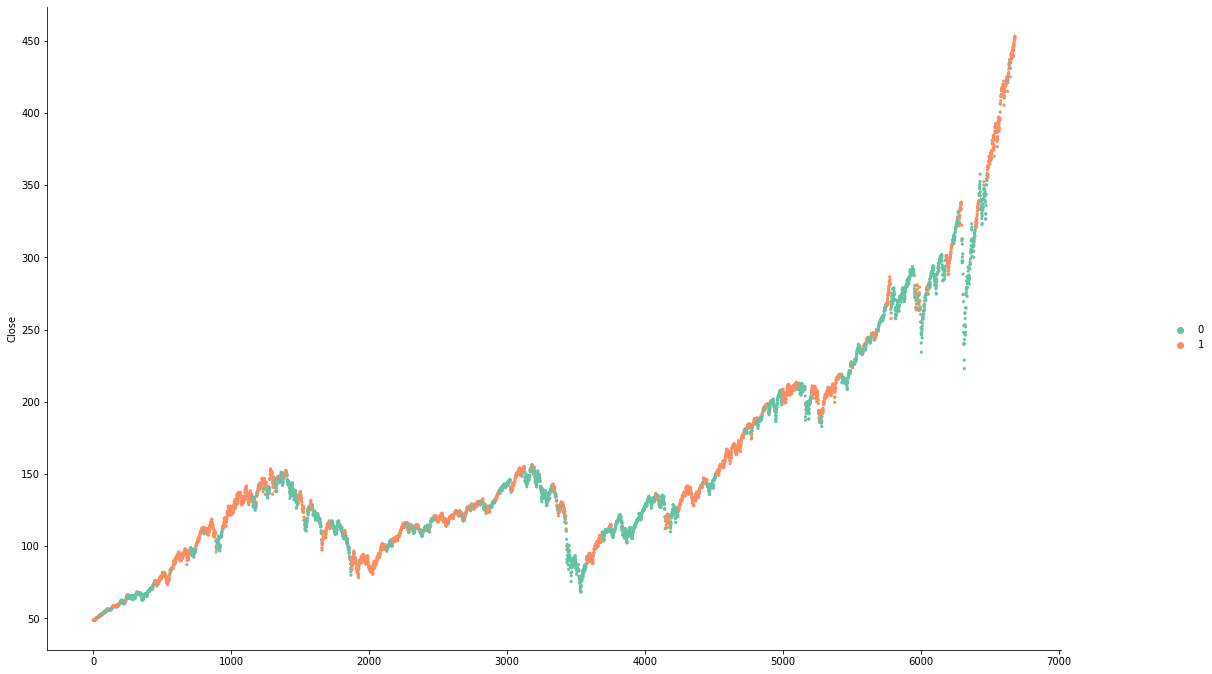

In [365]:
plot = sns.relplot(x=range(0,len(current_state)), y="Close", data=data[2*Neff+1:], hue=current_state, 
            linewidth = 0, palette="Set2", s = 10);
plot.fig.set_size_inches(18,10)

In [323]:
returns = pd.DataFrame(data = return_map[max_occurrence])
for i in range(0, states):
    if(i is not max_occurrence):
        print(i)
        returns[i] = pd.Series(return_map[i]);

#sns.pairplot(data = returns, height=3);

0
1


In [324]:
distribution = model.get_stationary_distribution();
for i in range(0, states):
    print("Regime {0}: {1}".format(i, distribution[i]));

Regime 0: 0.5220064740271063
Regime 1: 0.47799352597289363


In [325]:
print("Model Score: {0}".format(model.score(observations)));

Model Score: 51789.516245951454


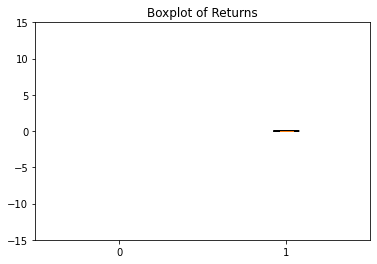

In [327]:
# Boxplot of returns
fig, ax = plt.subplots()
ax.set(ylim=(-15, 15));
ax.set_title("Boxplot of Returns");
ax.boxplot(return_map.values(), notch=True, vert = True, autorange = True)
ax.set_xticklabels(return_map.keys());